In [1]:
from transformers import pipeline, set_seed
import torch
import torch.nn as nn
import torch.nn.functional as F
import tiktoken
import numpy as np
import math

In [2]:
generator = pipeline('text-generation', model='gpt2')

In [3]:
set_seed(42)
text = generator("I am a doctor who", max_length=50, num_return_sequences=5)
text

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'I am a doctor who is highly skeptical of people being educated about their qualifications," he said.\n\n"My colleagues and I have heard from people like me who are scared to go to university because they feel that this isn\'t an option. The'},
 {'generated_text': "I am a doctor who performs a procedure by making the patient feel the end of the patient's rope, the beginning of the patient's rope, even when he has been in the life of the patient for a while. Since it's only my procedure"},
 {'generated_text': 'I am a doctor who works with patients, so if anyone has ever seen a bad sign in a patient\'s health, that has to be addressed," she said.\n\nGangster\n\nShe said it was vital to take the latest research'},
 {'generated_text': "I am a doctor who teaches free love to young children of different ethnicities, religions and ethnicity. In fact, the government's program of free love to children is particularly effective, because children are trained to be free loving 

In [4]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('gpt2')
state_dict = model.state_dict()

for key, value in state_dict.items():
    print(key, value.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [5]:
# how to know the gpt configuration from the state_dict
# https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel
# https://huggingface.co/transformers/model_doc/gpt2.html#gpt2config
from transformers import GPT2Config
config = GPT2Config.from_pretrained('gpt2')
config

c:\Users\AUC\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.41.1",
  "use_cache": true,
  "vocab_size": 50257
}

In [6]:
learning_rate = 3e-4
num_epochs = 10
top = 1000000
dropout_rate: float = 0.1

In [7]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

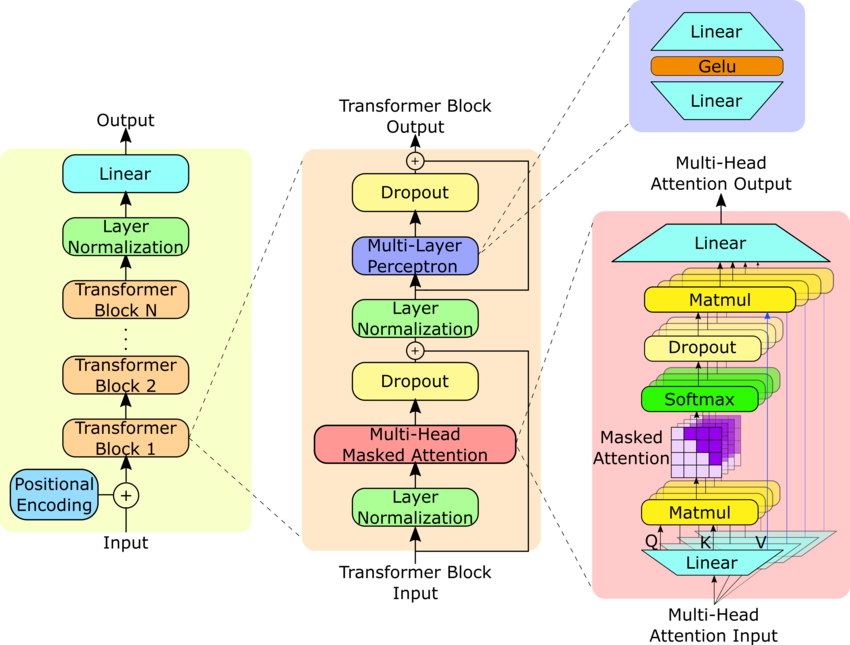

In [8]:
from dataclasses import dataclass

@dataclass
class GPT2Config:
    block_size: int = 0
    vocab_size: int = 0
    n_embd: int = 0
    n_layer: int = 0
    n_head: int = 0

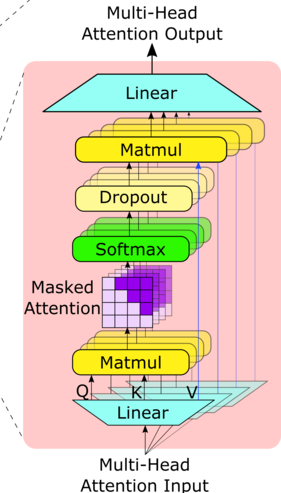

In [66]:
def scaled_dot_product_attention(q,k,v,mask=None):
    d_k = q.size(-1)
    qk = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        qk = qk.permute(1, 0, 2, 3) + mask
        qk = qk.permute(1, 0, 2, 3)
    qk = F.softmax(qk, dim=-1)
    new_qkv = torch.matmul(qk, v)
    return new_qkv

class Multihead_Self_Attention(nn.Module):
    def __init__(self, config):
        super(Multihead_Self_Attention, self).__init__()
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.softmax = nn.Softmax(dim=-1)
        self.std_scaler = 1

    def forward(self,x,mask=None):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        y = self.c_proj(y)
        return y

In [67]:
class mlp(nn.Module):
    def __init__(self,config):
        super(mlp,self).__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.activation = nn.GELU(approximate='tanh')
        self.std_scaler = 1
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.activation(x)
        x = self.c_proj(x)
        return x

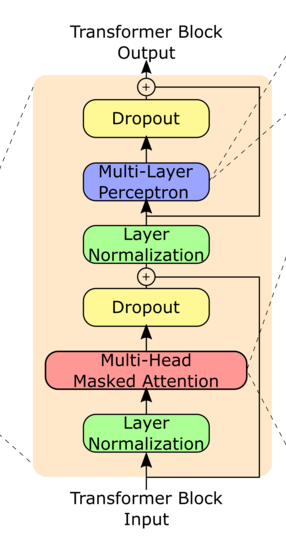

In [68]:
class Block(nn.Module):
    def __init__(self,config):
        super(Block, self).__init__()
        self.attn = Multihead_Self_Attention(config)
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.mlp = mlp(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.dropout = nn.Dropout(dropout_rate)
        self.std_scaler = 1
    def forward(self, x):
    
        resdual_x = x
        x = self.ln_1(x)
        x = self.attn(x) + resdual_x

        resdual_x = x
        x = self.ln_2(x)
        x = self.mlp(x) + resdual_x
        return x

In [12]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('gpt2')
state_dict = model.state_dict()

for key, value in state_dict.items():
    print(key, value.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [13]:
class PostionalEncoding(nn.Module):
    def __init__(self,max_seq_len,d_model):
        super(PostionalEncoding,self).__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.encoding = torch.zeros(self.max_seq_len,self.d_model)

    def forward(self,x):
        _,_,a,b =x.size()
        even_index = torch.arange(0,self.d_model,2).float()
        domenator = torch.pow(10000,even_index/self.d_model)
        position = torch.arange(0,a).unsqueeze(1)
        PE_even = torch.sin(position/domenator)
        PE_odd = torch.cos(position/domenator)
        stacked = torch.stack([PE_even,PE_odd],dim=2)
        PE_flatten = torch.flatten(stacked,start_dim=1,end_dim=2)
        return PE_flatten

In [14]:
class SentenceEmbedding(nn.Module):
    def __init__(self, config):
        super(SentenceEmbedding,self).__init__()
        self.embedding = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_encoder = PostionalEncoding(config.block_size,config.n_embd)
        self.dropout = nn.Dropout(p=dropout_rate)

    def batch_tokenize(self, batch):

        def tokenize(sentence):
            gpt_encoder = tiktoken.get_encoding('gpt2')
            tokens = gpt_encoder.encode(sentence)
            tokens = torch.tensor(tokens,dtype = torch.long).unsqueeze(0)
            return tokens
        tokenized = []
        for sentence_num in range(len(batch)):
           tokenized.append(tokenize(batch[sentence_num]))

        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x):
        x = self.batch_tokenize(x)
        x = self.embedding(x)
        pos = self.position_encoder(x).to(get_device())
        x = self.dropout(x + pos)
        return x

In [69]:
class myGPT(nn.Module):
    def __init__(self, config):
        super(myGPT, self).__init__()  
        self.config = config
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(config.vocab_size, config.n_embd),
            'wpe': nn.Embedding(config.block_size, config.n_embd),
            'h': nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            'ln_f': nn.LayerNorm(config.n_embd)
        })
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # weight sharing
        self.transformer['wte'].weight = self.lm_head.weight
        # apply weight initialization
        self.apply(self.initionalization)
        
    def initionalization(self,model):
        std_linear = 0.02
        std_embedding = 0.01
        if hasattr(model, 'std_scaler'):
            std_linear = (2 * self.config.n_layer) ** -0.5
            std_embedding = (2 * self.config.n_layer) ** -0.5
        if isinstance(model,nn.Linear):
            nn.init.normal_(model.weight, mean = 0,std = std_linear)
            if model.bias is not None:
                nn.init.zeros_(model.bias)
        elif isinstance(model,nn.Embedding):
            nn.init.normal_(model.weight,mean=0,std=std_embedding) # following the offical openAI implementation

    def forward(self, x,targets = None):
        B, T = x.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=x.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(x) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb

        for block in self.transformer.h:
            x = block(x)
            
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    
    @classmethod
    def from_pretrained(cls, model_type):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPT2Config(**config_args)
        model = myGPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

In [70]:
model = myGPT.from_pretrained(model_type = 'gpt2')
model

loading weights from pretrained gpt: gpt2


myGPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (attn): Multihead_Self_Attention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (softmax): Softmax(dim=-1)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): mlp(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (activation): GELU(approximate='tanh')
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [76]:
model = myGPT.from_pretrained(model_type='gpt2')
model.eval()

# Set parameters and seed
max_seq_len = 50
max_returned_seq = 5
set_seed(42)

# Tokenizer setup
gpt_encoder = tiktoken.get_encoding('gpt2')
tokens = gpt_encoder.encode("I am a doctor who")
tokens = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)
tokens = tokens.repeat(max_returned_seq, 1)

# Sampling loop
sample_rng = torch.Generator()
sample_rng.manual_seed(42)

while tokens.size(1) < max_seq_len:
    with torch.no_grad():
        logits, _ = model(tokens)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)

        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1, generator=sample_rng)
        xcol = torch.gather(topk_indices, -1, ix)
        tokens = torch.cat((tokens, xcol), dim=1)

# Decode and print generated sequences
for i in range(max_returned_seq):
    generated_tokens = tokens[i, :].tolist()
    generated_text = gpt_encoder.decode(generated_tokens)
    print(generated_text)

loading weights from pretrained gpt: gpt2
I am a doctor who has spent my past two decades trying to learn about how society affects people. We all need to come together.

In the face of a growing concern over homelessness and growing public fears over climate change, the Department for Environment
I am a doctor who will continue to treat patients and educate the public about the issues.

We work to help doctors and nurses understand the need for safe and effective surgery in our community, and we will respond to demand for new treatments and procedures
I am a doctor who lives in a post office just south of Washington, D.C. and works with all my colleagues, but I've learned so much about our planet through my many contacts in the last two decades. As an American worker,
I am a doctor who loves to read," Zobrist told the New York Daily News in January. "When you go for a walk with me or look for a place to eat, I have to do that. Most of a trip is spent
I am a doctor who works in every h

## Loding and training on my own data

In [72]:
class DataLoader:
    def __init__(self, batch_size, block_size):
        self.batch_size = batch_size
        self.block_size = block_size
        self.pointer = 0
        self.data = ''
        with open('data/input.txt', 'r') as file:
            self.data = file.read()
        self.tokens = tiktoken.get_encoding('gpt2').encode(self.data)
        self.n_batches = len(self.tokens) // (self.batch_size * self.block_size)

    def next_batch(self):
        start = self.pointer
        end = start + self.batch_size * self.block_size
        if end + 1 > len(self.tokens):
            raise IndexError("End of data reached")
        
        mini_tokens = self.tokens[start:end + 1]
        x = torch.tensor(mini_tokens[:-1], dtype=torch.long).view(self.batch_size, self.block_size)
        y = torch.tensor(mini_tokens[1:], dtype=torch.long).view(self.batch_size, self.block_size)
        self.pointer += self.batch_size * self.block_size
        return x, y

In [81]:
Block_size = 10
Batch_size = 8
config = GPT2Config(block_size=Block_size, vocab_size=50257, n_embd=768, n_layer=12, n_head=12)
model = myGPT(config)
model = model.to(get_device())
x,y = DataLoader(batch_size=Batch_size, block_size=Block_size).next_batch()
logits,loss = model.forward(x,y)
print(logits.size(), loss) # I am expecting to have a loss equal to the cross entropy loss which is -log(probability) 
                            # where each word follows uniform distription so the probability should be 1/vocb_size = 1/50257 = 0.0000199
                            # so the loss should be -log(0.0000199) = 10.8

torch.Size([8, 10, 50257]) tensor(10.9761, grad_fn=<NllLossBackward0>)


In [85]:
torch.set_float32_matmul_precision('high')
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(Batch_size,Block_size)
print(f"number of batches: {dataloader.n_batches}")
for i in range(50):
    optimizer.zero_grad()
    x,y = dataloader.next_batch()
    #with torch.autocast(device_type=get_device(),dtype=torch.bfloat16):
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f"epoch {i} loss: {loss.item()}")

number of batches: 4225
epoch 0 loss: 4.357063293457031
epoch 1 loss: 4.5395121574401855
epoch 2 loss: 5.897879600524902
epoch 3 loss: 5.47465705871582
epoch 4 loss: 5.037493705749512
epoch 5 loss: 6.002510070800781
epoch 6 loss: 5.469587802886963
epoch 7 loss: 6.325193881988525
epoch 8 loss: 6.1695990562438965
epoch 9 loss: 6.117032051086426
epoch 10 loss: 7.082440376281738
epoch 11 loss: 6.9459733963012695
epoch 12 loss: 6.947746276855469
epoch 13 loss: 6.658649444580078
epoch 14 loss: 7.083596229553223
epoch 15 loss: 6.533642768859863
epoch 16 loss: 7.726431846618652
epoch 17 loss: 6.766976833343506
epoch 18 loss: 6.191364765167236
epoch 19 loss: 5.950019836425781
epoch 20 loss: 7.192535400390625
epoch 21 loss: 7.08676290512085
epoch 22 loss: 6.0599164962768555
epoch 23 loss: 7.007905006408691
epoch 24 loss: 6.230193138122559
epoch 25 loss: 7.2240495681762695
epoch 26 loss: 6.881623268127441
epoch 27 loss: 7.543034553527832
epoch 28 loss: 8.020257949829102
epoch 29 loss: 6.477315425

In [77]:
# Verify parameter count
pretrained_model = GPT2LMHeadModel.from_pretrained('gpt2')
pretrained_params = sum(p.numel() for p in pretrained_model.parameters())
custom_params = sum(p.numel() for p in model.parameters())

print(f"Pre-trained model parameters: {pretrained_params}")
print(f"Custom model parameters: {custom_params}")

if pretrained_params == custom_params:
    print("Parameter counts match.")
else:
    print("Parameter counts do not match.")

Pre-trained model parameters: 124439808
Custom model parameters: 124439808
Parameter counts match.
